# Semantic Search of Memes on Twitter

## Requirements

In [ ]:
!pip install stop-words

## Load corpus and vocabulary from django model

In [71]:
import os
import codecs

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words
import nltk
nltk.download('perluniprops')
from nltk.tokenize import sent_tokenize, word_tokenize

os.environ['DJANGO_SETTINGS_MODULE'] = 'annotationsite.settings'
import django
from django.db.utils import OperationalError
django.setup()

from tweets.models import Annotation, Target

phase_range = (52100, 104100)

annotations = Annotation.objects.filter(
        media_id__gt=phase_range[0]).filter(
        media_id__lte=phase_range[1]).exclude(
        created_by__username='magdalena').order_by()

images = {'img_ids':[], 'urls':[], 'local_urls': [], 'targets':[]}
texts, descriptions, interpretations = [], [], []

for i, a in enumerate(annotations.all()):
    texts.append(codecs.escape_decode(a.text_in_media)[0].decode()[2:-1])
    descriptions.append(codecs.escape_decode(a.description_of_media)[0].decode()[2:-1])
    interpretations.append(codecs.escape_decode(a.interpretation)[0].decode()[2:-1])
    images['img_ids'].append(i)
    images['urls'].append(a.media.url)
    images['local_urls'].append(a.media.local_image.url)
    images['targets'].append(a.target.id)

# spanish_stop_words = get_stop_words('spanish')
# vectorizer = CountVectorizer(lowercase=True, binary=False, stop_words=spanish_stop_words)
# x = vectorizer.fit(texts + descriptions + interpretations)
# vocab_idx2word = vectorizer.get_feature_names()

# print('using {} words: '.format(len(vocab_idx2word)))
# print(vocab_idx2word)

word2idx = {}

def transform(texts):
    tokens = []
    for t in texts:
        words = word_tokenize(t.lower())
        sent = []
        for w in words:
            if w not in word2idx:
                word2idx[w] = len(word2idx)
            sent.append(word2idx[w])
        tokens.append(sent)
    return tokens

images['texts'] = transform(texts)
images['descriptions'] = transform(descriptions)
images['interpretations'] = transform(interpretations)

targets_names = {}
for t in Target.objects.all():
    targets_names[t.id] = t.name

data = {'images':images, 'targets_names':targets_names, 'vocab': word2idx}

[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/jeperez/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


In [ ]:
import json
with open('./media/MemesDataSet/datainfo.json', 'w') as f:
    json.dump(data, f)

In [73]:
len(word2idx)

8669

In [57]:
import os
import shutil
for idx, file_path, target in zip(data['images']['img_ids'], data['images']['local_urls'], data['images']['targets']):
    if os.path.isfile('.'+file_path):
        shutil.copy('.'+file_path, './media/MemesDataSet/{0}/img_{1:07d}.jpg'.format(data['targets_names'][target], idx))

In [ ]:
'hola cuba linda.'.strip().split()

In [ ]:
!top

In [ ]:
#You have to download the spanish stopwords first with nltk.download()
import nltk  
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation  
from sklearn.feature_extraction.text import CountVectorizer       

#stopword list to use
spanish_stopwords = stopwords.words('spanish')

#spanish stemmer
stemmer = SnowballStemmer('spanish')

#punctuation to remove
non_words = list(punctuation)  
#we add spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

stemmer = SnowballStemmer('spanish')  
def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):  
    # remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    # tokenize
    tokens =  word_tokenize(text)

    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

vectorizer = CountVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

## Features Extraction

In [5]:
import json
with open('./media/MemesDataSet/datainfo.json', 'r') as f:
    data = json.load(f)
data['images']['local_urls']

['/media/tweet_medias/1132950528584015872_D7kMgMxXYAAfAAU.jpg',
 '/media/tweet_medias/1132951089098084352_D7kNA02VUAAc8xb.jpg',
 '/media/tweet_medias/1132951235596890112_D7kNJWmXsAA9NFj.jpg',
 '/media/tweet_medias/1132951862611795968_D7kNt2aX4AA_6pZ.jpg',
 '/media/tweet_medias/1132951905225850880_D7kNwVKWwAAQnv5.jpg',
 '/media/tweet_medias/1132951943255662592_D7kNyi1XoAA_1pJ.jpg',
 '/media/tweet_medias/1132952039154212864_D7kN4IFXYAAcVer.jpg',
 '/media/tweet_medias/1132952063363690496_D7kN5iRWsAAP__E.jpg',
 '/media/tweet_medias/1132952096058142720_D7kN7cEUcAA6u3H.jpg',
 '/media/tweet_medias/1132952434454802432_D7kOPIsXsAAel6w.jpg',
 '/media/tweet_medias/1132952575681191936_D7kOXWzXYAA3CEt.jpg',
 '/media/tweet_medias/1132952800512663553_D7kOkcXXYAEziui.jpg',
 '/media/tweet_medias/1132952865037869057_D7kOoMvX4AEMT5H.jpg',
 '/media/tweet_medias/1132953036857511937_D7kOyM0XkAEhjvp.jpg',
 '/media/tweet_medias/1132953128557535232_D7kO3ibW4AAczhR.jpg',
 '/media/tweet_medias/113295326275428352

### HOG

In [33]:
import skimage.feature as feat
import skimage.transform as trans
import skimage.io as io
import numpy as np
import h5py
import sys

f = h5py.File('./media/MemesDataSet/features.hdf5', 'w')
dset = f.create_dataset("hog_features", (52000,128))

def toUINT8(image) :
    if image.dtype == np.float64 :
        image = image * 255
    elif image.dtype == np.uint16 :
        image = image >> 8        
    image[image<0]=0
    image[image>255]=255
    image = image.astype(np.uint8, copy=False)
    return image

def readImage(filename):
    """ readImage using skimage """    
    image = io.imread(filename, as_gray = True)    
    image = toUINT8(image)                 
    return image

for i, (img_path, url) in enumerate(zip(data['images']['local_urls'], data['images']['urls'])):
    sys.stdout.write('\r{0:05d} {1:40s} {2:50s}'.format(i, url, img_path))
    try:
        image = readImage('.'+img_path)
    except:
        dset[i] = np.zeros(128)
    else:
        image = trans.resize(image, (64,64))
        image = toUINT8(image)    
        fd = feat.hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), feature_vector = True)
        dset[i] = fd

f.close()

51999 https://t.co/GNOJfd0wkl                  /media/tweet_medias/1137463056127184896_D8kUn32XUAA-QaR.jpgg

### ResNet

In [6]:
import sys
import time

import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

images_t = torch.zeros(52000, 3, 224, 224)
for i, (img_path, url) in enumerate(zip(data['images']['local_urls'], data['images']['urls'])):
    sys.stdout.write('\r{0:05d} {1:40s} {2:50s}'.format(i, url, img_path))
    try:
        img = Image.open('.'+img_path).convert("RGB")
    except:
        pass
    else:
        images_t[i,:,:,:] = normalize(to_tensor(scaler(img)))

torch.save(images_t, 'images.pt')

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 31309824000 bytes. Error code 12 (Cannot allocate memory)


### Create dataset hdf5 with the features

In [7]:
import h5py
import torch

features = torch.load('./media/MemesDataSet/resnet152_feats.pt')
f = h5py.File('./media/MemesDataSet/resnet_features.hdf5', 'w')
dset = f.create_dataset("resnet152_features", data=features.numpy())
f.close()

# Classifier

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC  # support vector machine classifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import (ClusterCentroids, RandomUnderSampler,
                                     NearMiss,
                                     InstanceHardnessThreshold,
                                     CondensedNearestNeighbour,
                                     EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours,
                                     AllKNN,
                                     NeighbourhoodCleaningRule,
                                     OneSidedSelection)

c0 = ("Base Dummy", DummyClassifier(strategy='stratified'))
c1 = ("Decision Tree", DecisionTreeClassifier())
c2 = ("Gaussian Naive Bayes", GaussianNB())
c3 = ("KNN", KNeighborsClassifier(n_neighbors=7))
c4 = ('Linear-SVM', LinearSVC(C=1.0, max_iter=10000))

classifiers = [c4]
# classifiers = [c0, c1, c2, c3]

# f = h5py.File('./media/MemesDataSet/features.hdf5', 'r')
# X = f['hog_features'].value

f = h5py.File('./media/MemesDataSet/resnet_features.hdf5', 'r')
X = f['resnet152_features'].value

y = data['images']['targets']

# remove dudoso
dudoso_ids = [i for i in range(len(y)) if y[i] == 3]
y = [t for i, t in enumerate(y) if i not in dudoso_ids]
X = np.delete(X, dudoso_ids, 0)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=37, stratify=y)

# sampler = NearMiss(version=2)

for name, clf in classifiers:
    metrics = {'conf_mat': [], 'acc': [], 'f1-score': [], 'precision': [], 'recall': []}
    
    for _ in range(10):    
        sampler = RandomUnderSampler(random_state=0)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
        #clf = make_pipeline(sampler, clf)

#         print(len(y_resampled), len([i for i in range(len(y_resampled)) if y_resampled[i] == 1]), len([i for i in range(len(y_resampled)) if y_resampled[i] == 2]), len([i for i in range(len(y_resampled)) if y_resampled[i] == 4]))

        # clf.fit(X_train, y_train)
        # predictions = cross_val_predict(clf, X_test, y_test, cv=10)  ## cv es la cantidad de folds

        cros_val_preds = cross_val_predict(clf, X_resampled, y_resampled, cv=10)  ## cv es la cantidad de folds
        
        
#         print("Accuracy:", metrics.accuracy_score(y_resampled, cros_val_preds))
#         print("Metricas:")
#         print(metrics.classification_report(y_resampled, cros_val_preds))
        
        metrics['conf_mat'].append(confusion_matrix(y_resampled, cros_val_preds))
        metrics['acc'].append(accuracy_score(y_resampled, cros_val_preds))
        metrics['f1-score'].append(f1_score(y_resampled, cros_val_preds, average='macro'))
        metrics['recall'].append(recall_score(y_resampled, cros_val_preds, average='macro'))
        metrics['precision'].append(precision_score(y_resampled, cros_val_preds, average='macro'))
        
        
    print("----------------")
    print("Resultados para clasificador: ", name)
    
    print("Acc promedio:", np.array(metrics['acc']).mean())
    print("Precision promedio:",np.array(metrics['precision']).mean())
    print("Recall promedio:",np.array(metrics['recall']).mean())
    print("F1-score promedio:",np.array(metrics['f1-score']).mean())
    
    cm = np.array(metrics['conf_mat']).mean(axis=0)
    print("Conf-Mat promedio:", )
    
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cm, classes=['Meme', 'No-Meme', 'Sticker'],
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(cm, classes=['Meme', 'No-Meme', 'Sticker'], normalize=True,
                          title='Normalized confusion matrix')
    plt.show()
    
    print("----------------\n\n")

f.close()

/home/jeperez/code/annotationsite/.venv3/lib/python3.5/site-packages/ipykernel_launcher.py:35: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


/home/jeperez/code/annotationsite/.venv3/lib/python3.5/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


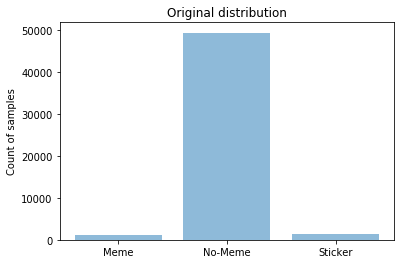

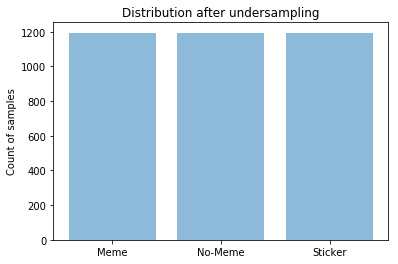

In [21]:
import matplotlib.pyplot as plt
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler

y = data['images']['targets']
f = h5py.File('./media/MemesDataSet/resnet_features.hdf5', 'r')
X = f['resnet152_features'].value

# remove dudoso
dudoso_ids = [i for i in range(len(y)) if y[i] == 3]
y = [t for i, t in enumerate(y) if i not in dudoso_ids]
X = np.delete(X, dudoso_ids, 0)

labels = ['Meme', 'No-Meme', 'Sticker']
counts = [len([x for x in y if x==1]), len([x for x in y if x==2]), len([x for x in y if x==4])]

x = np.arange(len(labels))

plt.bar(x, counts, align='center', alpha=0.5)
plt.xticks(x, labels)
plt.ylabel('Count of samples')
plt.title('Original distribution')
plt.show()

sampler = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = sampler.fit_resample(X, y)
counts = [len([x for x in y_resampled if x==1]), len([x for x in y_resampled if x==2]), len([x for x in y_resampled if x==4])]

plt.bar(x, counts, align='center', alpha=0.5)
plt.xticks(x, labels)
plt.ylabel('Count of samples')
plt.title('Distribution after undersampling')
plt.show()

# Semantic Search

In [2]:
from torch.utils.data import Dataset, DataLoader
from random import randint

class MemeToTextDataset(Dataset):
    def __init__(self, embeddings, data, img_features, interval):
        self.img_features = img_features
        
        self.wordvectors = embeddings
        self.vocab = {}
        for k, v in data['vocab'].items():
            self.vocab[v] = k
        
        self.texts = []
        self.text_embeddings = []
        self.ids = []
        for i, (target, text, desc, interp) in enumerate(zip(data['images']['targets'], data['images']['texts'], data['images']['interpretations'], data['images']['descriptions'])):
            if i >= interval[0] and i <= interval[1] and (target == 1 or target == 4):
#                 if len(text):
#                     self.ids.append(i)
#                     self.text_embeddings.append(self.__text_emmbeding(text))
#                     self.texts.append(self.__sentence(text))
                if len(desc):
                    self.ids.append(i)
                    self.text_embeddings.append(self.__text_emmbeding(desc))
                    self.texts.append(self.__sentence(desc))
                if len(interp):
                    self.ids.append(i)
                    self.text_embeddings.append(self.__text_emmbeding(interp))
                    self.texts.append(self.__sentence(interp))
    
    def __getitem__(self, i):
        idx = self.ids[i]
        n_i = randint(0, len(self.texts)-1)
        while self.ids[n_i] == idx:
            n_i = randint(0, len(self.texts)-1)
        return idx, self.img_features[idx], torch.FloatTensor(self.text_embeddings[i]), self.texts[i], torch.FloatTensor(self.text_embeddings[n_i]), self.texts[n_i]
    
    def __len__(self):
        return len(self.texts)
    
    def __sentence(self, text):
        words = []
        for t in text:
            words.append(self.vocab[t])
        return ' '.join(words)
    
    def __text_emmbeding(self, text):
        result = []
        for t in text:
            s = self.vocab[t]
            while len(s) >= 1 and s[0] in ['/', '-', '¡', '¿', '.', ',', ';', ':', '\'', '"']:
                s = s[1:]
            
            try:
                vec = self.wordvectors[s]
            except:
#                 print('error with word "{}" reduced to "{}"'.format(self.vocab[t], s))
                pass
            else:
                result.append(torch.from_numpy(vec).view(1, -1))
        if len(result):
            return torch.mean(torch.cat(result, dim=0), dim=0)
        else:
            return torch.from_numpy(self.wordvectors['ambiguo'])

def get_train_loader(embeddings, data, img_features, batch_size):
    interval = (0, 49999)
    dset = MemeToTextDataset(embeddings, data, img_features, interval)
    return DataLoader(dset, batch_size, shuffle=True)

def get_test_loader(embeddings, data, img_features, batch_size):
    interval = (50000, 51999)
    dset = MemeToTextDataset(embeddings, data, img_features, interval)
    return DataLoader(dset, batch_size, shuffle=False)


In [3]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, dropout_p=0.5, pretrained_model_path=''):
        super(MLP, self).__init__()
        
        self.in_drop = nn.Dropout(dropout_p)
        
        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fc1_drop = nn.Dropout(dropout_p)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc2_drop = nn.Dropout(dropout_p)
        
        self.fc3 = nn.Linear(hidden_size, out_size)
        
        self.__init_layers()

    def __init_layers(self):
        for m in self.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        h = self.in_drop(x)
        h = self.fc1_drop(torch.relu(self.fc1(h)))
        h = self.fc2_drop(torch.relu(self.fc2(h)))
        return self.fc3(h)

In [4]:
import h5py
from gensim.models.keyedvectors import KeyedVectors

f = h5py.File('./media/MemesDataSet/resnet_features.hdf5', 'r')
img_features = f['resnet152_features'].value
f.close()

wordvectors_file_vec = 'fasttext-sbwc.vec'
cantidad = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)

/home/jeperez/code/annotationsite/.venv3/lib/python3.5/site-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """


In [5]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [6]:
import sys
import numpy as np
from torch.autograd import Variable
from sklearn.metrics import average_precision_score

# text_encoder = MLP(300, 1024, 128)
visual_encoder = MLP(2048, 4096, 300)

# optimizer = torch.optim.SGD([{'params': text_encoder.parameters()}, 
#                              {'params': visual_encoder.parameters()}], lr=0.001)
optimizer = torch.optim.SGD(visual_encoder.parameters(), lr=0.0001)

# criterion = nn.MSELoss()
criterion = TripletLoss(margin=2.0)

# pdist = nn.PairwiseDistance(p=2)

train_loader = get_train_loader(wordvectors, data, img_features, 16)
test_loader = get_test_loader(wordvectors, data, img_features, 200)

print(len(train_loader.dataset), len(test_loader.dataset))

train_losses, test_losses, maps = [], [], []
early_stopping, max_map = 0, 0
for e in range(100000):
#     text_encoder.train()
    visual_encoder.train()
    total_train_loss = 0
    for i, (ids, v_feats, p_t_feats, p_texts, n_t_feats, n_texts) in enumerate(train_loader):
        p_t_feats = Variable(p_t_feats)
        n_t_feats = Variable(n_t_feats)
        v_feats = Variable(v_feats)
                
#         p_t_enc = text_encoder(p_t_feats)
#         n_t_enc = text_encoder(n_t_feats)
        v_enc = visual_encoder(v_feats)

        loss = criterion(v_enc, p_t_feats, n_t_feats)
        total_train_loss += loss.item()
        
        sys.stdout.write('\r epoch: {0:03d} iter: {1:03d} train-loss: {2:.5f}'.format(e, i, loss.item()))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_losses.append(total_train_loss/len(train_loader))        
    print('')
#     text_encoder.eval()
    visual_encoder.eval()
    
    ids, v_feats, p_t_feats, p_texts, n_t_feats, n_texts = list(test_loader)[0]
    p_t_feats = Variable(p_t_feats)
    n_t_feats = Variable(n_t_feats)
    v_feats = Variable(v_feats)
    
    with torch.no_grad():
#         p_t_enc = text_encoder(p_t_feats)
#         n_t_enc = text_encoder(n_t_feats)
        v_enc = visual_encoder(v_feats)

    loss = criterion(v_enc, p_t_feats, n_t_feats)
    test_losses.append(loss.item())
    
    total_map_score = 0
    last_idx = -1
    q_count = 0
    for i in range(v_enc.size(0)):
        if ids[i] != last_idx:
            last_idx = ids[i]
            q_count += 1
            dists = torch.sum((v_enc[i, :] - p_t_feats)**2, dim=1)
#             dists = torch.rand(v_enc.size(0)) * 20

            y_true = np.array([1 if idx == ids[i] else 0 for idx in ids])
            total_map_score += average_precision_score(y_true, -1 * dists.numpy())

    maps.append(total_map_score/q_count)
    
    early_stopping += 1
    if total_map_score > max_map:
        early_stopping = 0
        max_map = total_map_score
    
    sys.stdout.write('\r epoch: {0:03d} avg-train-loss: {1:.5f} test-loss: {2:.5f} mAP: {3:.3f}\n'.format(e, total_train_loss/len(train_loader), loss.item(), total_map_score/q_count))
    
    if early_stopping == 100:
        print('Early stopping at epoch {}'.format(e))
        break
        
import matplotlib.pyplot as plt

f1 = plt.figure(1)
ax1 = f1.add_subplot(111);
ax1.set_title('Loss performance')    
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(train_losses, c='r', label='train')
ax1.plot(test_losses, c='b', label='test')
legend = ax1.legend(loc='upper center', shadow=True, fontsize='x-large')
f1.show()

f2 = plt.figure(2)
ax2 = f2.add_subplot(111);
ax2.set_title('mAP performance')    
ax2.set_xlabel('epochs')
ax2.set_ylabel('mAP')
ax2.plot(maps, c='b')
f2.show()

3628 46
 epoch: 000 iter: 226 train-loss: 3.55688
 epoch: 000 avg-train-loss: 2.57987 test-loss: 2.73012 mAP: 0.105
 epoch: 001 iter: 226 train-loss: 3.24796
 epoch: 001 avg-train-loss: 2.51464 test-loss: 2.83412 mAP: 0.111
 epoch: 002 iter: 226 train-loss: 2.48436
 epoch: 002 avg-train-loss: 2.39841 test-loss: 2.43618 mAP: 0.136
 epoch: 003 iter: 226 train-loss: 3.07261
 epoch: 003 avg-train-loss: 2.35613 test-loss: 2.46965 mAP: 0.140
 epoch: 004 iter: 226 train-loss: 3.23485
 epoch: 004 avg-train-loss: 2.27428 test-loss: 2.37955 mAP: 0.143
 epoch: 005 iter: 226 train-loss: 3.07271
 epoch: 005 avg-train-loss: 2.22401 test-loss: 2.18790 mAP: 0.149
 epoch: 006 iter: 226 train-loss: 2.24262
 epoch: 006 avg-train-loss: 2.25554 test-loss: 2.20964 mAP: 0.164
 epoch: 007 iter: 226 train-loss: 1.88569
 epoch: 007 avg-train-loss: 2.17038 test-loss: 1.99615 mAP: 0.168
 epoch: 008 iter: 226 train-loss: 1.07215
 epoch: 008 avg-train-loss: 2.18069 test-loss: 1.89479 mAP: 0.174
 epoch: 009 iter: 22

 epoch: 076 iter: 226 train-loss: 0.59790
 epoch: 076 avg-train-loss: 1.25543 test-loss: 1.20147 mAP: 0.234
 epoch: 077 iter: 226 train-loss: 1.84072
 epoch: 077 avg-train-loss: 1.29435 test-loss: 1.33438 mAP: 0.235
 epoch: 078 iter: 226 train-loss: 2.35940
 epoch: 078 avg-train-loss: 1.26436 test-loss: 1.70265 mAP: 0.243
 epoch: 079 iter: 226 train-loss: 1.72210
 epoch: 079 avg-train-loss: 1.25760 test-loss: 1.24470 mAP: 0.233
 epoch: 080 iter: 226 train-loss: 1.23095
 epoch: 080 avg-train-loss: 1.29894 test-loss: 1.17030 mAP: 0.235
 epoch: 081 iter: 226 train-loss: 1.01190
 epoch: 081 avg-train-loss: 1.23718 test-loss: 1.44822 mAP: 0.238
 epoch: 082 iter: 226 train-loss: 1.19715
 epoch: 082 avg-train-loss: 1.22331 test-loss: 1.38748 mAP: 0.230
 epoch: 083 iter: 226 train-loss: 1.62821
 epoch: 083 avg-train-loss: 1.27045 test-loss: 0.96695 mAP: 0.236
 epoch: 084 iter: 226 train-loss: 1.77340
 epoch: 084 avg-train-loss: 1.24430 test-loss: 1.26728 mAP: 0.242
 epoch: 085 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 132 iter: 226 train-loss: 0.75431
 epoch: 132 avg-train-loss: 1.05420 test-loss: 1.40648 mAP: 0.277
 epoch: 133 iter: 226 train-loss: 0.89676
 epoch: 133 avg-train-loss: 1.04788 test-loss: 1.44801 mAP: 0.278
 epoch: 134 iter: 226 train-loss: 0.68438
 epoch: 134 avg-train-loss: 1.08799 test-loss: 1.40930 mAP: 0.280
 epoch: 135 iter: 226 train-loss: 0.55945
 epoch: 135 avg-train-loss: 1.06463 test-loss: 1.14975 mAP: 0.269
 epoch: 136 iter: 226 train-loss: 0.33699
 epoch: 136 avg-train-loss: 1.09427 test-loss: 1.27980 mAP: 0.270
 epoch: 137 iter: 226 train-loss: 0.59562
 epoch: 137 avg-train-loss: 1.05890 test-loss: 1.32230 mAP: 0.277
 epoch: 138 iter: 226 train-loss: 1.64760
 epoch: 138 avg-train-loss: 1.04499 test-loss: 1.30089 mAP: 0.281
 epoch: 139 iter: 226 train-loss: 2.49982
 epoch: 139 avg-train-loss: 1.05166 test-loss: 1.04926 mAP: 0.281
 epoch: 140 iter: 226 train-loss: 0.35341
 epoch: 140 avg-train-loss: 1.05954 test-loss: 1.11466 mAP: 0.283
 epoch: 141 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 163 iter: 226 train-loss: 1.09291
 epoch: 163 avg-train-loss: 0.96810 test-loss: 1.09132 mAP: 0.285
 epoch: 164 iter: 226 train-loss: 1.65612
 epoch: 164 avg-train-loss: 1.00740 test-loss: 1.46131 mAP: 0.283
 epoch: 165 iter: 226 train-loss: 0.34777
 epoch: 165 avg-train-loss: 0.99376 test-loss: 1.15812 mAP: 0.284
 epoch: 166 iter: 226 train-loss: 1.54310
 epoch: 166 avg-train-loss: 0.97709 test-loss: 1.40221 mAP: 0.281
 epoch: 167 iter: 226 train-loss: 0.32087
 epoch: 167 avg-train-loss: 1.01698 test-loss: 0.79292 mAP: 0.282
 epoch: 168 iter: 226 train-loss: 0.94165
 epoch: 168 avg-train-loss: 1.04975 test-loss: 1.01922 mAP: 0.282
 epoch: 169 iter: 226 train-loss: 0.70023
 epoch: 169 avg-train-loss: 0.96356 test-loss: 1.12297 mAP: 0.282
 epoch: 170 iter: 226 train-loss: 0.96261
 epoch: 170 avg-train-loss: 0.99403 test-loss: 1.10275 mAP: 0.282
 epoch: 171 iter: 226 train-loss: 1.27993
 epoch: 171 avg-train-loss: 1.00028 test-loss: 0.71969 mAP: 0.280
 epoch: 172 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 194 iter: 226 train-loss: 0.96926
 epoch: 194 avg-train-loss: 0.91381 test-loss: 1.01896 mAP: 0.297
 epoch: 195 iter: 226 train-loss: 0.93874
 epoch: 195 avg-train-loss: 1.00737 test-loss: 1.18596 mAP: 0.301
 epoch: 196 iter: 226 train-loss: 0.89085
 epoch: 196 avg-train-loss: 0.94007 test-loss: 1.29002 mAP: 0.300
 epoch: 197 iter: 226 train-loss: 0.28836
 epoch: 197 avg-train-loss: 0.96534 test-loss: 1.26912 mAP: 0.299
 epoch: 198 iter: 226 train-loss: 1.10725
 epoch: 198 avg-train-loss: 0.95421 test-loss: 1.09133 mAP: 0.298
 epoch: 199 iter: 226 train-loss: 1.07795
 epoch: 199 avg-train-loss: 0.91851 test-loss: 1.11080 mAP: 0.300
 epoch: 200 iter: 226 train-loss: 0.91821
 epoch: 200 avg-train-loss: 0.95707 test-loss: 1.13956 mAP: 0.301
 epoch: 201 iter: 226 train-loss: 1.34835
 epoch: 201 avg-train-loss: 0.95353 test-loss: 1.31223 mAP: 0.303
 epoch: 202 iter: 226 train-loss: 1.02877
 epoch: 202 avg-train-loss: 0.92484 test-loss: 1.54488 mAP: 0.299
 epoch: 203 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 222 iter: 226 train-loss: 0.89165
 epoch: 222 avg-train-loss: 0.92513 test-loss: 1.07063 mAP: 0.303
 epoch: 223 iter: 226 train-loss: 0.71203
 epoch: 223 avg-train-loss: 0.88561 test-loss: 1.18005 mAP: 0.303
 epoch: 224 iter: 226 train-loss: 1.41618
 epoch: 224 avg-train-loss: 0.88872 test-loss: 1.51631 mAP: 0.300
 epoch: 225 iter: 226 train-loss: 1.02674
 epoch: 225 avg-train-loss: 0.91343 test-loss: 0.76436 mAP: 0.299
 epoch: 226 iter: 226 train-loss: 0.35116
 epoch: 226 avg-train-loss: 0.93369 test-loss: 1.03827 mAP: 0.299
 epoch: 227 iter: 226 train-loss: 0.73838
 epoch: 227 avg-train-loss: 0.90403 test-loss: 1.37410 mAP: 0.303
 epoch: 228 iter: 226 train-loss: 0.37623
 epoch: 228 avg-train-loss: 0.90299 test-loss: 1.34764 mAP: 0.306
 epoch: 229 iter: 226 train-loss: 0.70356
 epoch: 229 avg-train-loss: 0.93734 test-loss: 1.14079 mAP: 0.306
 epoch: 230 iter: 226 train-loss: 0.63139
 epoch: 230 avg-train-loss: 0.91467 test-loss: 0.96386 mAP: 0.304
 epoch: 231 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 253 iter: 226 train-loss: 0.44787
 epoch: 253 avg-train-loss: 0.86141 test-loss: 0.85858 mAP: 0.312
 epoch: 254 iter: 226 train-loss: 1.87398
 epoch: 254 avg-train-loss: 0.87487 test-loss: 1.06639 mAP: 0.312
 epoch: 255 iter: 226 train-loss: 1.10232
 epoch: 255 avg-train-loss: 0.87032 test-loss: 1.17696 mAP: 0.311
 epoch: 256 iter: 226 train-loss: 0.87727
 epoch: 256 avg-train-loss: 0.85251 test-loss: 1.05890 mAP: 0.313
 epoch: 257 iter: 226 train-loss: 2.13880
 epoch: 257 avg-train-loss: 0.84812 test-loss: 1.33447 mAP: 0.311
 epoch: 258 iter: 226 train-loss: 0.23797
 epoch: 258 avg-train-loss: 0.87022 test-loss: 1.18913 mAP: 0.311
 epoch: 259 iter: 226 train-loss: 1.07711
 epoch: 259 avg-train-loss: 0.86230 test-loss: 0.91304 mAP: 0.314
 epoch: 260 iter: 226 train-loss: 0.84576
 epoch: 260 avg-train-loss: 0.85459 test-loss: 1.11696 mAP: 0.315
 epoch: 261 iter: 226 train-loss: 0.43192
 epoch: 261 avg-train-loss: 0.83665 test-loss: 1.11584 mAP: 0.315
 epoch: 262 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 283 iter: 226 train-loss: 0.42114
 epoch: 283 avg-train-loss: 0.79576 test-loss: 1.41412 mAP: 0.312
 epoch: 284 iter: 226 train-loss: 0.07720
 epoch: 284 avg-train-loss: 0.82400 test-loss: 1.67400 mAP: 0.314
 epoch: 285 iter: 226 train-loss: 0.44517
 epoch: 285 avg-train-loss: 0.82290 test-loss: 1.07039 mAP: 0.315
 epoch: 286 iter: 226 train-loss: 0.58394
 epoch: 286 avg-train-loss: 0.81555 test-loss: 0.87712 mAP: 0.314
 epoch: 287 iter: 226 train-loss: 0.14287
 epoch: 287 avg-train-loss: 0.78990 test-loss: 1.28691 mAP: 0.312
 epoch: 288 iter: 226 train-loss: 0.39804
 epoch: 288 avg-train-loss: 0.78262 test-loss: 1.03218 mAP: 0.315
 epoch: 289 iter: 226 train-loss: 0.96570
 epoch: 289 avg-train-loss: 0.83149 test-loss: 1.22043 mAP: 0.314
 epoch: 290 iter: 226 train-loss: 0.69566
 epoch: 290 avg-train-loss: 0.81662 test-loss: 1.17809 mAP: 0.316
 epoch: 291 iter: 226 train-loss: 0.51141
 epoch: 291 avg-train-loss: 0.83601 test-loss: 1.01806 mAP: 0.316
 epoch: 292 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 312 iter: 226 train-loss: 1.00561
 epoch: 312 avg-train-loss: 0.79202 test-loss: 1.05391 mAP: 0.314
 epoch: 313 iter: 226 train-loss: 0.80916
 epoch: 313 avg-train-loss: 0.80483 test-loss: 1.58696 mAP: 0.319
 epoch: 314 iter: 226 train-loss: 1.12017
 epoch: 314 avg-train-loss: 0.80511 test-loss: 1.08798 mAP: 0.319
 epoch: 315 iter: 226 train-loss: 0.58532
 epoch: 315 avg-train-loss: 0.80619 test-loss: 0.80449 mAP: 0.319
 epoch: 316 iter: 226 train-loss: 0.09566
 epoch: 316 avg-train-loss: 0.78377 test-loss: 1.08316 mAP: 0.317
 epoch: 317 iter: 226 train-loss: 0.45421
 epoch: 317 avg-train-loss: 0.76468 test-loss: 1.07658 mAP: 0.316
 epoch: 318 iter: 226 train-loss: 0.47298
 epoch: 318 avg-train-loss: 0.77567 test-loss: 1.02690 mAP: 0.315
 epoch: 319 iter: 226 train-loss: 0.75396
 epoch: 319 avg-train-loss: 0.85289 test-loss: 1.31018 mAP: 0.318
 epoch: 320 iter: 226 train-loss: 0.38263
 epoch: 320 avg-train-loss: 0.84107 test-loss: 1.21272 mAP: 0.319
 epoch: 321 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 342 iter: 226 train-loss: 0.24821
 epoch: 342 avg-train-loss: 0.77410 test-loss: 1.17815 mAP: 0.319
 epoch: 343 iter: 226 train-loss: 0.59559
 epoch: 343 avg-train-loss: 0.73629 test-loss: 0.49632 mAP: 0.319
 epoch: 344 iter: 226 train-loss: 0.96384
 epoch: 344 avg-train-loss: 0.78772 test-loss: 0.79159 mAP: 0.320
 epoch: 345 iter: 226 train-loss: 0.58411
 epoch: 345 avg-train-loss: 0.78691 test-loss: 1.24561 mAP: 0.320
 epoch: 346 iter: 226 train-loss: 0.81845
 epoch: 346 avg-train-loss: 0.74628 test-loss: 1.29051 mAP: 0.320
 epoch: 347 iter: 226 train-loss: 0.56289
 epoch: 347 avg-train-loss: 0.77737 test-loss: 1.00591 mAP: 0.320
 epoch: 348 iter: 226 train-loss: 0.01777
 epoch: 348 avg-train-loss: 0.74873 test-loss: 1.25969 mAP: 0.320
 epoch: 349 iter: 226 train-loss: 0.23903
 epoch: 349 avg-train-loss: 0.73749 test-loss: 1.08129 mAP: 0.320
 epoch: 350 iter: 226 train-loss: 0.16056
 epoch: 350 avg-train-loss: 0.73685 test-loss: 1.12394 mAP: 0.320
 epoch: 351 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 373 iter: 226 train-loss: 0.53033
 epoch: 373 avg-train-loss: 0.69549 test-loss: 0.92930 mAP: 0.327
 epoch: 374 iter: 226 train-loss: 0.20233
 epoch: 374 avg-train-loss: 0.77054 test-loss: 0.96687 mAP: 0.326
 epoch: 375 iter: 226 train-loss: 1.27988
 epoch: 375 avg-train-loss: 0.73144 test-loss: 1.31971 mAP: 0.326
 epoch: 376 iter: 226 train-loss: 1.31034
 epoch: 376 avg-train-loss: 0.73254 test-loss: 1.06857 mAP: 0.326
 epoch: 377 iter: 226 train-loss: 0.37198
 epoch: 377 avg-train-loss: 0.67638 test-loss: 1.07836 mAP: 0.340
 epoch: 378 iter: 226 train-loss: 0.76589
 epoch: 378 avg-train-loss: 0.75788 test-loss: 1.27049 mAP: 0.324
 epoch: 379 iter: 226 train-loss: 0.62468
 epoch: 379 avg-train-loss: 0.73804 test-loss: 1.01248 mAP: 0.337
 epoch: 380 iter: 226 train-loss: 1.28190
 epoch: 380 avg-train-loss: 0.74770 test-loss: 0.73668 mAP: 0.339
 epoch: 381 iter: 226 train-loss: 0.52786
 epoch: 381 avg-train-loss: 0.75967 test-loss: 0.69823 mAP: 0.338
 epoch: 382 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 403 iter: 226 train-loss: 0.21346
 epoch: 403 avg-train-loss: 0.71457 test-loss: 1.05791 mAP: 0.326
 epoch: 404 iter: 226 train-loss: 0.60092
 epoch: 404 avg-train-loss: 0.69505 test-loss: 1.17841 mAP: 0.327
 epoch: 405 iter: 226 train-loss: 0.21961
 epoch: 405 avg-train-loss: 0.72074 test-loss: 0.98757 mAP: 0.326
 epoch: 406 iter: 226 train-loss: 0.84370
 epoch: 406 avg-train-loss: 0.71880 test-loss: 0.68940 mAP: 0.321
 epoch: 407 iter: 226 train-loss: 0.91328
 epoch: 407 avg-train-loss: 0.73822 test-loss: 0.77204 mAP: 0.319
 epoch: 408 iter: 226 train-loss: 0.65177
 epoch: 408 avg-train-loss: 0.69222 test-loss: 0.77866 mAP: 0.321
 epoch: 409 iter: 226 train-loss: 0.52098
 epoch: 409 avg-train-loss: 0.69587 test-loss: 1.33026 mAP: 0.327
 epoch: 410 iter: 226 train-loss: 0.06957
 epoch: 410 avg-train-loss: 0.74712 test-loss: 1.03546 mAP: 0.326
 epoch: 411 iter: 226 train-loss: 0.73495
 epoch: 411 avg-train-loss: 0.70390 test-loss: 1.01475 mAP: 0.326
 epoch: 412 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 433 iter: 226 train-loss: 0.29935
 epoch: 433 avg-train-loss: 0.73581 test-loss: 0.76262 mAP: 0.323
 epoch: 434 iter: 226 train-loss: 0.93712
 epoch: 434 avg-train-loss: 0.71110 test-loss: 1.08459 mAP: 0.321
 epoch: 435 iter: 226 train-loss: 0.64005
 epoch: 435 avg-train-loss: 0.67506 test-loss: 0.98885 mAP: 0.336
 epoch: 436 iter: 226 train-loss: 0.63455
 epoch: 436 avg-train-loss: 0.67562 test-loss: 0.93693 mAP: 0.335
 epoch: 437 iter: 226 train-loss: 0.77586
 epoch: 437 avg-train-loss: 0.67719 test-loss: 0.94219 mAP: 0.334
 epoch: 438 iter: 226 train-loss: 0.29897
 epoch: 438 avg-train-loss: 0.69866 test-loss: 1.21908 mAP: 0.335
 epoch: 439 iter: 226 train-loss: 0.08571
 epoch: 439 avg-train-loss: 0.68821 test-loss: 0.87484 mAP: 0.334
 epoch: 440 iter: 226 train-loss: 0.36953
 epoch: 440 avg-train-loss: 0.66809 test-loss: 1.01348 mAP: 0.325
 epoch: 441 iter: 226 train-loss: 1.27561
 epoch: 441 avg-train-loss: 0.69759 test-loss: 0.87529 mAP: 0.328
 epoch: 442 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 463 iter: 226 train-loss: 0.77104
 epoch: 463 avg-train-loss: 0.71006 test-loss: 0.72186 mAP: 0.329
 epoch: 464 iter: 226 train-loss: 0.80136
 epoch: 464 avg-train-loss: 0.65186 test-loss: 0.99346 mAP: 0.343
 epoch: 465 iter: 226 train-loss: 0.76881
 epoch: 465 avg-train-loss: 0.68735 test-loss: 0.89750 mAP: 0.343
 epoch: 466 iter: 226 train-loss: 0.30047
 epoch: 466 avg-train-loss: 0.67727 test-loss: 0.99915 mAP: 0.345
 epoch: 467 iter: 226 train-loss: 0.05496
 epoch: 467 avg-train-loss: 0.68954 test-loss: 1.32842 mAP: 0.345
 epoch: 468 iter: 226 train-loss: 0.59918
 epoch: 468 avg-train-loss: 0.69065 test-loss: 1.33469 mAP: 0.346
 epoch: 469 iter: 226 train-loss: 0.95978
 epoch: 469 avg-train-loss: 0.64326 test-loss: 0.97986 mAP: 0.346
 epoch: 470 iter: 226 train-loss: 0.76652
 epoch: 470 avg-train-loss: 0.66115 test-loss: 1.29572 mAP: 0.342
 epoch: 471 iter: 226 train-loss: 0.57986
 epoch: 471 avg-train-loss: 0.67398 test-loss: 1.43052 mAP: 0.341
 epoch: 472 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 493 iter: 226 train-loss: 0.52709
 epoch: 493 avg-train-loss: 0.65563 test-loss: 0.58632 mAP: 0.330
 epoch: 494 iter: 226 train-loss: 0.62726
 epoch: 494 avg-train-loss: 0.68402 test-loss: 0.79038 mAP: 0.332
 epoch: 495 iter: 226 train-loss: 0.74624
 epoch: 495 avg-train-loss: 0.63837 test-loss: 0.82356 mAP: 0.323
 epoch: 496 iter: 226 train-loss: 0.52872
 epoch: 496 avg-train-loss: 0.65905 test-loss: 0.83578 mAP: 0.333
 epoch: 497 iter: 226 train-loss: 0.37315
 epoch: 497 avg-train-loss: 0.64596 test-loss: 1.02606 mAP: 0.350
 epoch: 498 iter: 226 train-loss: 0.44362
 epoch: 498 avg-train-loss: 0.67500 test-loss: 0.64186 mAP: 0.332
 epoch: 499 iter: 226 train-loss: 0.62313
 epoch: 499 avg-train-loss: 0.66088 test-loss: 0.77242 mAP: 0.348
 epoch: 500 iter: 226 train-loss: 0.60831
 epoch: 500 avg-train-loss: 0.65097 test-loss: 0.99544 mAP: 0.334
 epoch: 501 iter: 226 train-loss: 0.16718
 epoch: 501 avg-train-loss: 0.63530 test-loss: 0.90491 mAP: 0.344
 epoch: 502 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 524 iter: 226 train-loss: 0.51584
 epoch: 524 avg-train-loss: 0.65198 test-loss: 0.92679 mAP: 0.349
 epoch: 525 iter: 226 train-loss: 0.27200
 epoch: 525 avg-train-loss: 0.60459 test-loss: 0.93017 mAP: 0.345
 epoch: 526 iter: 226 train-loss: 0.22434
 epoch: 526 avg-train-loss: 0.64534 test-loss: 1.37646 mAP: 0.349
 epoch: 527 iter: 226 train-loss: 0.55340
 epoch: 527 avg-train-loss: 0.64843 test-loss: 0.90847 mAP: 0.350
 epoch: 528 iter: 226 train-loss: 0.54042
 epoch: 528 avg-train-loss: 0.64776 test-loss: 1.13560 mAP: 0.350
 epoch: 529 iter: 226 train-loss: 0.69500
 epoch: 529 avg-train-loss: 0.66764 test-loss: 1.07327 mAP: 0.360
 epoch: 530 iter: 226 train-loss: 1.59190
 epoch: 530 avg-train-loss: 0.65475 test-loss: 1.15040 mAP: 0.361
 epoch: 531 iter: 226 train-loss: 0.58298
 epoch: 531 avg-train-loss: 0.63459 test-loss: 0.99949 mAP: 0.361
 epoch: 532 iter: 226 train-loss: 0.78640
 epoch: 532 avg-train-loss: 0.62172 test-loss: 0.88067 mAP: 0.360
 epoch: 533 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 551 iter: 226 train-loss: 0.80861
 epoch: 551 avg-train-loss: 0.63376 test-loss: 1.19444 mAP: 0.349
 epoch: 552 iter: 226 train-loss: 0.34286
 epoch: 552 avg-train-loss: 0.62436 test-loss: 0.98544 mAP: 0.347
 epoch: 553 iter: 226 train-loss: 0.68562
 epoch: 553 avg-train-loss: 0.65233 test-loss: 1.05487 mAP: 0.360
 epoch: 554 iter: 226 train-loss: 0.95547
 epoch: 554 avg-train-loss: 0.61809 test-loss: 0.97453 mAP: 0.348
 epoch: 555 iter: 226 train-loss: 0.41812
 epoch: 555 avg-train-loss: 0.59548 test-loss: 0.79564 mAP: 0.361
 epoch: 556 iter: 226 train-loss: 0.94711
 epoch: 556 avg-train-loss: 0.59077 test-loss: 1.08881 mAP: 0.366
 epoch: 557 iter: 226 train-loss: 0.50367
 epoch: 557 avg-train-loss: 0.63811 test-loss: 1.10519 mAP: 0.354
 epoch: 558 iter: 226 train-loss: 1.11477
 epoch: 558 avg-train-loss: 0.59358 test-loss: 0.82778 mAP: 0.353
 epoch: 559 iter: 226 train-loss: 0.16401
 epoch: 559 avg-train-loss: 0.62023 test-loss: 0.59176 mAP: 0.352
 epoch: 560 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 581 iter: 226 train-loss: 0.11417
 epoch: 581 avg-train-loss: 0.63753 test-loss: 1.14936 mAP: 0.359
 epoch: 582 iter: 226 train-loss: 0.58001
 epoch: 582 avg-train-loss: 0.60361 test-loss: 1.15595 mAP: 0.356
 epoch: 583 iter: 226 train-loss: 1.05743
 epoch: 583 avg-train-loss: 0.62039 test-loss: 1.13487 mAP: 0.356
 epoch: 584 iter: 226 train-loss: 1.89704
 epoch: 584 avg-train-loss: 0.61906 test-loss: 1.06992 mAP: 0.356
 epoch: 585 iter: 226 train-loss: 1.31182
 epoch: 585 avg-train-loss: 0.63441 test-loss: 0.95052 mAP: 0.342
 epoch: 586 iter: 226 train-loss: 0.66414
 epoch: 586 avg-train-loss: 0.64423 test-loss: 1.28424 mAP: 0.356
 epoch: 587 iter: 226 train-loss: 0.42315
 epoch: 587 avg-train-loss: 0.63991 test-loss: 1.23652 mAP: 0.356
 epoch: 588 iter: 226 train-loss: 0.34461
 epoch: 588 avg-train-loss: 0.63583 test-loss: 1.02880 mAP: 0.356
 epoch: 589 iter: 226 train-loss: 0.22458
 epoch: 589 avg-train-loss: 0.60084 test-loss: 1.02024 mAP: 0.355
 epoch: 590 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 611 iter: 226 train-loss: 0.13050
 epoch: 611 avg-train-loss: 0.60202 test-loss: 1.09804 mAP: 0.353
 epoch: 612 iter: 226 train-loss: 0.31278
 epoch: 612 avg-train-loss: 0.62042 test-loss: 1.01690 mAP: 0.365
 epoch: 613 iter: 226 train-loss: 0.43731
 epoch: 613 avg-train-loss: 0.58768 test-loss: 0.91037 mAP: 0.353
 epoch: 614 iter: 226 train-loss: 0.35807
 epoch: 614 avg-train-loss: 0.58579 test-loss: 1.06865 mAP: 0.352
 epoch: 615 iter: 226 train-loss: 1.09539
 epoch: 615 avg-train-loss: 0.61975 test-loss: 0.92032 mAP: 0.365
 epoch: 616 iter: 226 train-loss: 0.82485
 epoch: 616 avg-train-loss: 0.62010 test-loss: 0.95338 mAP: 0.366
 epoch: 617 iter: 226 train-loss: 0.53032
 epoch: 617 avg-train-loss: 0.58623 test-loss: 1.17743 mAP: 0.346
 epoch: 618 iter: 226 train-loss: 0.37635
 epoch: 618 avg-train-loss: 0.61692 test-loss: 0.53222 mAP: 0.346
 epoch: 619 iter: 226 train-loss: 0.68035
 epoch: 619 avg-train-loss: 0.59696 test-loss: 1.08081 mAP: 0.346
 epoch: 620 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 642 iter: 226 train-loss: 1.44442
 epoch: 642 avg-train-loss: 0.59241 test-loss: 0.94607 mAP: 0.358
 epoch: 643 iter: 226 train-loss: 0.41377
 epoch: 643 avg-train-loss: 0.56925 test-loss: 0.85904 mAP: 0.352
 epoch: 644 iter: 226 train-loss: 0.37780
 epoch: 644 avg-train-loss: 0.58849 test-loss: 0.98002 mAP: 0.366
 epoch: 645 iter: 226 train-loss: 0.46352
 epoch: 645 avg-train-loss: 0.59241 test-loss: 0.82393 mAP: 0.366
 epoch: 646 iter: 226 train-loss: 0.43638
 epoch: 646 avg-train-loss: 0.59143 test-loss: 0.77473 mAP: 0.359
 epoch: 647 iter: 226 train-loss: 0.52618
 epoch: 647 avg-train-loss: 0.56971 test-loss: 0.73842 mAP: 0.363
 epoch: 648 iter: 226 train-loss: 0.43594
 epoch: 648 avg-train-loss: 0.54996 test-loss: 1.11033 mAP: 0.362
 epoch: 649 iter: 226 train-loss: 1.31005
 epoch: 649 avg-train-loss: 0.59051 test-loss: 0.77494 mAP: 0.362
 epoch: 650 iter: 226 train-loss: 1.51483
 epoch: 650 avg-train-loss: 0.61874 test-loss: 1.08005 mAP: 0.364
 epoch: 651 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 672 iter: 226 train-loss: 0.56694
 epoch: 672 avg-train-loss: 0.57765 test-loss: 1.19388 mAP: 0.351
 epoch: 673 iter: 226 train-loss: 1.27079
 epoch: 673 avg-train-loss: 0.56727 test-loss: 0.79627 mAP: 0.356
 epoch: 674 iter: 226 train-loss: 0.21384
 epoch: 674 avg-train-loss: 0.53319 test-loss: 0.79045 mAP: 0.357
 epoch: 675 iter: 226 train-loss: 1.03491
 epoch: 675 avg-train-loss: 0.56995 test-loss: 0.75110 mAP: 0.356
 epoch: 676 iter: 226 train-loss: 0.58851
 epoch: 676 avg-train-loss: 0.57988 test-loss: 0.68050 mAP: 0.353
 epoch: 677 iter: 226 train-loss: 0.31249
 epoch: 677 avg-train-loss: 0.56832 test-loss: 0.80823 mAP: 0.369
 epoch: 678 iter: 226 train-loss: 0.97634
 epoch: 678 avg-train-loss: 0.60314 test-loss: 1.19427 mAP: 0.355
 epoch: 679 iter: 226 train-loss: 0.17193
 epoch: 679 avg-train-loss: 0.58836 test-loss: 0.98646 mAP: 0.353
 epoch: 680 iter: 226 train-loss: 0.10442
 epoch: 680 avg-train-loss: 0.55986 test-loss: 0.80159 mAP: 0.356
 epoch: 681 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 702 iter: 226 train-loss: 0.53545
 epoch: 702 avg-train-loss: 0.57432 test-loss: 0.93455 mAP: 0.355
 epoch: 703 iter: 226 train-loss: 0.74247
 epoch: 703 avg-train-loss: 0.55742 test-loss: 0.95791 mAP: 0.366
 epoch: 704 iter: 226 train-loss: 0.42605
 epoch: 704 avg-train-loss: 0.57393 test-loss: 1.17036 mAP: 0.363
 epoch: 705 iter: 226 train-loss: 0.26475
 epoch: 705 avg-train-loss: 0.54070 test-loss: 1.00460 mAP: 0.364
 epoch: 706 iter: 226 train-loss: 0.53319
 epoch: 706 avg-train-loss: 0.58142 test-loss: 0.80250 mAP: 0.350
 epoch: 707 iter: 226 train-loss: 0.84909
 epoch: 707 avg-train-loss: 0.57354 test-loss: 0.98938 mAP: 0.355
 epoch: 708 iter: 226 train-loss: 0.28440
 epoch: 708 avg-train-loss: 0.54442 test-loss: 0.70334 mAP: 0.370
 epoch: 709 iter: 226 train-loss: 1.16293
 epoch: 709 avg-train-loss: 0.55449 test-loss: 1.23479 mAP: 0.368
 epoch: 710 iter: 226 train-loss: 0.18666
 epoch: 710 avg-train-loss: 0.54041 test-loss: 1.04113 mAP: 0.368
 epoch: 711 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 729 iter: 226 train-loss: 0.65623
 epoch: 729 avg-train-loss: 0.55467 test-loss: 1.32996 mAP: 0.366
 epoch: 730 iter: 226 train-loss: 0.24930
 epoch: 730 avg-train-loss: 0.53710 test-loss: 0.93853 mAP: 0.366
 epoch: 731 iter: 226 train-loss: 0.44848
 epoch: 731 avg-train-loss: 0.57681 test-loss: 1.03779 mAP: 0.354
 epoch: 732 iter: 226 train-loss: 0.55422
 epoch: 732 avg-train-loss: 0.56170 test-loss: 0.81505 mAP: 0.354
 epoch: 733 iter: 226 train-loss: 0.42473
 epoch: 733 avg-train-loss: 0.52923 test-loss: 0.85627 mAP: 0.353
 epoch: 734 iter: 226 train-loss: 0.30386
 epoch: 734 avg-train-loss: 0.55386 test-loss: 0.61182 mAP: 0.353
 epoch: 735 iter: 226 train-loss: 1.10072
 epoch: 735 avg-train-loss: 0.53424 test-loss: 1.47179 mAP: 0.351
 epoch: 736 iter: 226 train-loss: 0.44410
 epoch: 736 avg-train-loss: 0.58551 test-loss: 0.86816 mAP: 0.366
 epoch: 737 iter: 226 train-loss: 0.34868
 epoch: 737 avg-train-loss: 0.53883 test-loss: 0.80813 mAP: 0.364
 epoch: 738 iter: 226 train-

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 epoch: 759 iter: 226 train-loss: 0.38800
 epoch: 759 avg-train-loss: 0.54877 test-loss: 1.13908 mAP: 0.350
 epoch: 760 iter: 226 train-loss: 1.09481
 epoch: 760 avg-train-loss: 0.56771 test-loss: 0.94036 mAP: 0.352
Early stopping at epoch 760


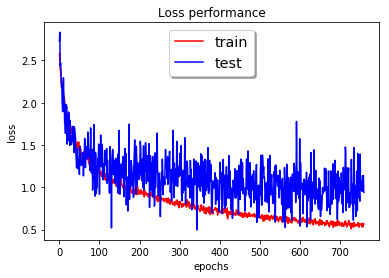

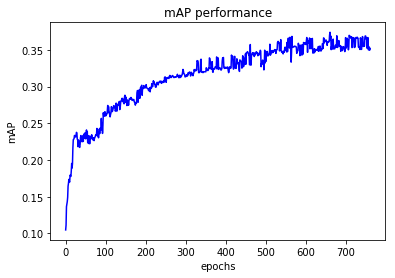

In [7]:
f1 = plt.figure(1)
ax1 = f1.add_subplot(111);
ax1.set_title('Loss performance')    
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.plot(train_losses, c='r', label='train')
ax1.plot(test_losses, c='b', label='test')
legend = ax1.legend(loc='upper center', shadow=True, fontsize='x-large')
f1.show()

f2 = plt.figure(2)
ax2 = f2.add_subplot(111);
ax2.set_title('mAP performance')    
ax2.set_xlabel('epochs')
ax2.set_ylabel('mAP')
ax2.plot(maps, c='b')
f2.show()